In [27]:
import os
import sys
import random
import warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
import seaborn as sns
sns.set_style("white")
%matplotlib inline

from tqdm import tqdm_notebook, tnrange
from itertools import chain
from skimage.io import imread, imshow, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from sklearn.model_selection import train_test_split

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.optimizers import *
from keras.losses import binary_crossentropy
from keras.regularizers import l2
from keras.initializers import he_normal

import tensorflow as tf

from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [2]:
img_size_ori = 101
img_size_target = 128

def upsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_target, img_size_target), mode='constant', preserve_range=True)
    
def downsample(img):
    if img_size_ori == img_size_target:
        return img
    return resize(img, (img_size_ori, img_size_ori), mode='constant', preserve_range=True)

In [3]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred = K.cast(y_pred, 'float32')
    y_pred_f = K.cast(K.greater(K.flatten(y_pred), 0.5), 'float32')
    intersection = y_true_f * y_pred_f
    score = 2. * K.sum(intersection) / (K.sum(y_true_f) + K.sum(y_pred_f))
    return score

def dice_loss(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = y_true_f * y_pred_f
    score = (2. * K.sum(intersection) + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return 1. - score

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def bce_logdice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - K.log(1. - dice_loss(y_true, y_pred))

def weighted_bce_loss(y_true, y_pred, weight):
    epsilon = 1e-7
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    logit_y_pred = K.log(y_pred / (1. - y_pred))
    loss = weight * (logit_y_pred * (1. - y_true) + 
                     K.log(1. + K.exp(-K.abs(logit_y_pred))) + K.maximum(-logit_y_pred, 0.))
    return K.sum(loss) / K.sum(weight)

def weighted_dice_loss(y_true, y_pred, weight):
    smooth = 1.
    w, m1, m2 = weight, y_true, y_pred
    intersection = (m1 * m2)
    score = (2. * K.sum(w * intersection) + smooth) / (K.sum(w * m1) + K.sum(w * m2) + smooth)
    loss = 1. - K.sum(score)
    return loss

def weighted_bce_dice_loss(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')
    # if we want to get same size of output, kernel size must be odd
    averaged_mask = K.pool2d(
            y_true, pool_size=(50, 50), strides=(1, 1), padding='same', pool_mode='avg')
    weight = K.ones_like(averaged_mask)
    w0 = K.sum(weight)
    weight = 5. * K.exp(-5. * K.abs(averaged_mask - 0.5))
    w1 = K.sum(weight)
    weight *= (w0 / w1)
    loss = weighted_bce_loss(y_true, y_pred, weight) + dice_loss(y_true, y_pred)
    return loss

In [5]:
train_df = pd.read_csv("data/train.csv", index_col="id", usecols=[0])
depths_df = pd.read_csv("data/depths.csv", index_col="id")
train_df = train_df.join(depths_df)
test_df = depths_df[~depths_df.index.isin(train_df.index)]

In [7]:
train_df["images"] = [np.array(load_img("data/train/images/{}.png".format(idx), grayscale=True)) / 255 
                      for idx in tqdm_notebook(train_df.index)]

A Jupyter Widget

In [8]:
train_df["masks"] = [np.array(load_img("data/train/masks/{}.png".format(idx), grayscale=True)) / 255
                     for idx in tqdm_notebook(train_df.index)]

A Jupyter Widget

In [9]:
train_df["coverage"] = train_df.masks.map(np.sum) / pow(img_size_ori, 2)

In [10]:
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
        
train_df["coverage_class"] = train_df.coverage.map(cov_to_class)

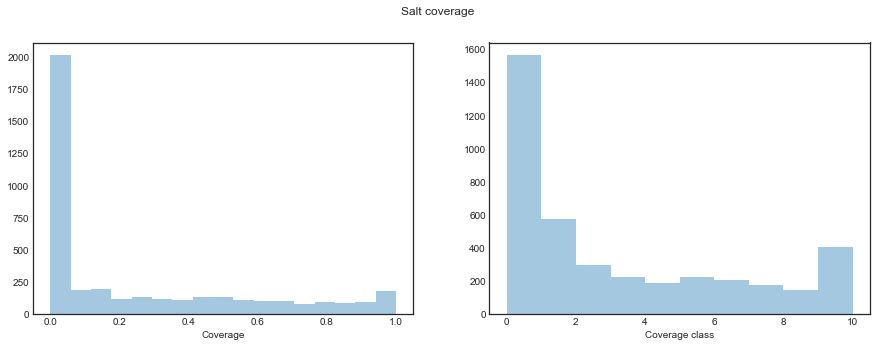

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))
sns.distplot(train_df.coverage, kde=False, ax=axs[0])
sns.distplot(train_df.coverage_class, bins=10, kde=False, ax=axs[1])
plt.suptitle("Salt coverage")
axs[0].set_xlabel("Coverage")
axs[1].set_xlabel("Coverage class")

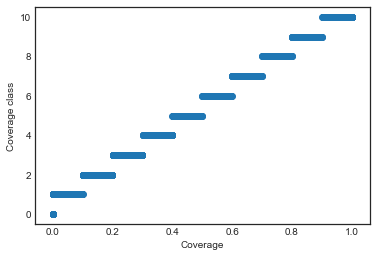

In [12]:
plt.scatter(train_df.coverage, train_df.coverage_class)
plt.xlabel("Coverage")
plt.ylabel("Coverage class")

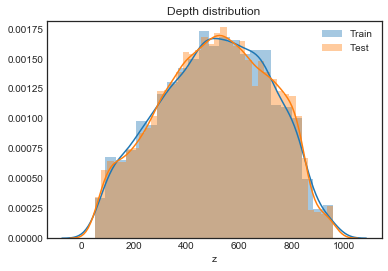

In [13]:
sns.distplot(train_df.z, label="Train")
sns.distplot(test_df.z, label="Test")
plt.legend()
plt.title("Depth distribution")

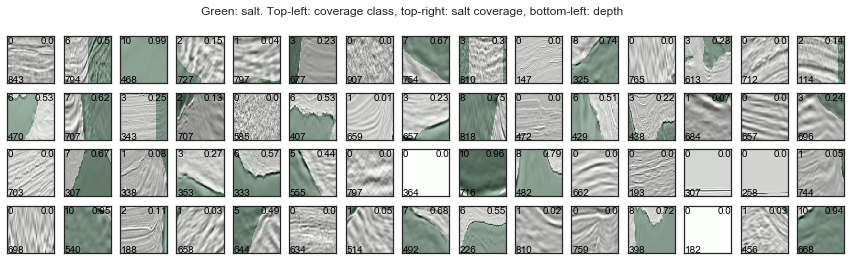

In [14]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(train_df.index[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [15]:
ids_train, ids_valid, x_train, x_valid, y_train, y_valid, cov_train, cov_test, depth_train, depth_test = train_test_split(
    train_df.index.values,
    np.array(train_df.images.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    np.array(train_df.masks.map(upsample).tolist()).reshape(-1, img_size_target, img_size_target, 1), 
    train_df.coverage.values,
    train_df.z.values,
    test_size=0.2, stratify=train_df.coverage_class, random_state=1337)

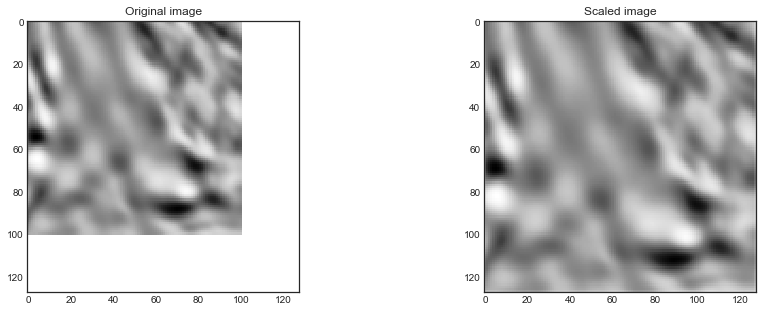

In [16]:
tmp_img = np.zeros((img_size_target, img_size_target), dtype=train_df.images.loc[ids_train[10]].dtype)
tmp_img[:img_size_ori, :img_size_ori] = train_df.images.loc[ids_train[10]]
fix, axs = plt.subplots(1, 2, figsize=(15,5))
axs[0].imshow(tmp_img, cmap="Greys")
axs[0].set_title("Original image")
axs[1].imshow(x_train[10].squeeze(), cmap="Greys")
axs[1].set_title("Scaled image")

In [17]:
def convlayer(inputs , filters , kernel_size , strides , activation = 'relu'):
    
    X = Conv2D(filters , kernel_size = (kernel_size , kernel_size) , strides = (strides , strides) , padding = 'same')(inputs)
    X = BatchNormalization()(X)
    X = Activation(activation)(X)
    
    if(activation != 'sigmoid'):
        sq = GlobalAveragePooling2D()(X)
        sq = Dense(int(filters / 4) , activation = 'relu')(sq)
        sq = Dense(filters , activation = 'sigmoid')(sq)
        sq = Reshape((1,1,filters))(sq)
        X = Multiply()([sq , X])
        
    return X

In [18]:
def resnet_block(inputs , filters , strides):
    
    identity = Conv2D(filters , kernel_size = (1 , 1) , strides = (strides , strides),
                      kernel_initializer = he_normal(2019) , kernel_regularizer = l2(1e-4), padding = 'same')(inputs)
    
    conv = Conv2D(filters , kernel_size = (3 , 3) , strides = (strides , strides) , 
                  kernel_initializer = he_normal(2019) , kernel_regularizer = l2(1e-4), padding = 'same')(inputs)
    conv = BatchNormalization()(conv)
    conv = Activation('relu')(conv)
    
    conv = Conv2D(filters , kernel_size = (3 , 3) , strides = (1 , 1),
                  kernel_initializer = he_normal(2019) , kernel_regularizer = l2(1e-4), padding = 'same')(conv)
    conv = BatchNormalization()(conv)
    
    output = Add()([identity , conv])
    output = Activation('relu')(output)
    
    sq = GlobalAveragePooling2D()(output)
    sq = Dense(int(filters / 4) , activation = 'relu')(sq)
    sq = Dense(filters , activation = 'sigmoid')(sq)
    sq = Reshape((1,1,filters))(sq)
    ex = Multiply()([sq , output])
    
    return ex

In [28]:
input_img = Input((img_size_target, img_size_target, 1), name='img')

res1 = resnet_block(input_img, filters = 4, strides = 1)

res1 = resnet_block(res1, filters = 4, strides = 1)

res2 = resnet_block(res1, filters = 8, strides = 2)

res2 = resnet_block(res2, filters = 8, strides = 1)

res3 = resnet_block(res2, filters = 16, strides = 2)

res3 = resnet_block(res3, filters = 16, strides = 1)

res4 = resnet_block(res3, filters = 32, strides = 2)

res4 = resnet_block(res4, filters = 32, strides = 1)

res5 = resnet_block(res4, filters = 64, strides = 2)

res5 = resnet_block(res5, filters = 64, strides = 1)

mid = convlayer(res5 , filters = 128, kernel_size = 3 , strides = 2 , activation = 'relu')
mid = convlayer(mid , filters = 128, kernel_size = 3 , strides = 1 , activation = 'relu')

up1 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (mid)
up1 = concatenate([up1, res5])
c1 = convlayer(up1 , filters = 64, kernel_size = 3 , strides = 1 , activation = 'relu')
c1 = convlayer(c1 , filters = 64, kernel_size = 3 , strides = 1 , activation = 'relu')

up2 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c1)
up2 = concatenate([up2, res4])
c2 = convlayer(up2 , filters = 32, kernel_size = 3 , strides = 1 , activation = 'relu')
c2 = convlayer(c2 , filters = 32, kernel_size = 3 , strides = 1 , activation = 'relu')

up3 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c2)
up3 = concatenate([up3, res3])
c3 = convlayer(up3 , filters = 16, kernel_size = 3 , strides = 1 , activation = 'relu')
c3 = convlayer(c3 , filters = 16, kernel_size = 3 , strides = 1 , activation = 'relu')

up4 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c3)
up4 = concatenate([up4, res2])
c4 = convlayer(up4 , filters = 8, kernel_size = 3 , strides = 1 , activation = 'relu')
c4 = convlayer(c4 , filters = 8, kernel_size = 3 , strides = 1 , activation = 'relu')

up5 = Conv2DTranspose(4, (2, 2), strides=(2, 2), padding='same') (c4)
up5 = concatenate([up5, res1], axis = 3)
c5 = convlayer(up5 , filters = 4, kernel_size = 3 , strides = 1 , activation = 'relu')
c5 = convlayer(c5 , filters = 4, kernel_size = 3 , strides = 1 , activation = 'relu')

outputs = convlayer(c5 , filters = 1, kernel_size = 1 , strides = 1 , activation = 'sigmoid')

model = Model(inputs=[input_img], outputs=[outputs])

model.compile(optimizer='adam', loss=bce_dice_loss, metrics=['accuracy']) 

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_45 (Conv2D)              (None, 128, 128, 4)  40          img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_34 (BatchNo (None, 128, 128, 4)  16          conv2d_45[0][0]                  
__________________________________________________________________________________________________
activation_34 (Activation)      (None, 128, 128, 4)  0           batch_normalization_34[0][0]     
__________________________________________________________________________________________________
conv2d_46 

dense_55 (Dense)                (None, 4)            68          global_average_pooling2d_28[0][0]
__________________________________________________________________________________________________
dense_56 (Dense)                (None, 16)           80          dense_55[0][0]                   
__________________________________________________________________________________________________
reshape_28 (Reshape)            (None, 1, 1, 16)     0           dense_56[0][0]                   
__________________________________________________________________________________________________
multiply_28 (Multiply)          (None, 32, 32, 16)   0           reshape_28[0][0]                 
                                                                 activation_45[0][0]              
__________________________________________________________________________________________________
conv2d_63 (Conv2D)              (None, 16, 16, 32)   4640        multiply_28[0][0]                
__________

activation_56 (Activation)      (None, 8, 8, 64)     0           batch_normalization_56[0][0]     
__________________________________________________________________________________________________
global_average_pooling2d_35 (Gl (None, 64)           0           activation_56[0][0]              
__________________________________________________________________________________________________
dense_69 (Dense)                (None, 16)           1040        global_average_pooling2d_35[0][0]
__________________________________________________________________________________________________
dense_70 (Dense)                (None, 64)           1088        dense_69[0][0]                   
__________________________________________________________________________________________________
reshape_35 (Reshape)            (None, 1, 1, 64)     0           dense_70[0][0]                   
__________________________________________________________________________________________________
multiply_3

reshape_43 (Reshape)            (None, 1, 1, 4)      0           dense_86[0][0]                   
__________________________________________________________________________________________________
multiply_43 (Multiply)          (None, 128, 128, 4)  0           reshape_43[0][0]                 
                                                                 activation_64[0][0]              
__________________________________________________________________________________________________
conv2d_85 (Conv2D)              (None, 128, 128, 4)  148         multiply_43[0][0]                
__________________________________________________________________________________________________
batch_normalization_65 (BatchNo (None, 128, 128, 4)  16          conv2d_85[0][0]                  
__________________________________________________________________________________________________
activation_65 (Activation)      (None, 128, 128, 4)  0           batch_normalization_65[0][0]     
__________

In [19]:
x_train = np.append(x_train, [np.fliplr(x) for x in x_train], axis=0)
y_train = np.append(y_train, [np.fliplr(x) for x in y_train], axis=0)

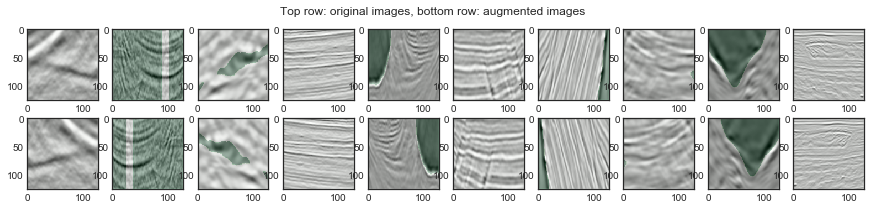

In [20]:
fig, axs = plt.subplots(2, 10, figsize=(15,3))
for i in range(10):
    axs[0][i].imshow(x_train[i].squeeze(), cmap="Greys")
    axs[0][i].imshow(y_train[i].squeeze(), cmap="Greens", alpha=0.3)
    axs[1][i].imshow(x_train[int(len(x_train)/2 + i)].squeeze(), cmap="Greys")
    axs[1][i].imshow(y_train[int(len(y_train)/2 + i)].squeeze(), cmap="Greens", alpha=0.3)
fig.suptitle("Top row: original images, bottom row: augmented images")

In [30]:
callbacks = [
    EarlyStopping(monitor= 'val_loss', patience=10, verbose=2, mode='min'),
    ReduceLROnPlateau(monitor= 'val_loss', factor=0.1, patience=5, verbose=2, min_lr=0.00001, mode='min'),
    ModelCheckpoint('tgs-res_unet.h5', monitor='val_loss', verbose=2, save_best_only=True , mode = 'min')
]

results = model.fit(x_train, y_train,
                    validation_data=[x_valid, y_valid], 
                    epochs=200,
                    batch_size=32,
                    callbacks=callbacks,shuffle=True)

Train on 6400 samples, validate on 800 samples
Epoch 1/200
6400/6400 [==============================] - ETA: 58:14 - loss: 1.6463 - acc: 0.52 - ETA: 29:09 - loss: 1.6171 - acc: 0.53 - ETA: 19:27 - loss: 1.6202 - acc: 0.54 - ETA: 14:36 - loss: 1.6142 - acc: 0.53 - ETA: 11:41 - loss: 1.6107 - acc: 0.53 - ETA: 9:45 - loss: 1.5943 - acc: 0.5319 - ETA: 8:22 - loss: 1.5880 - acc: 0.532 - ETA: 7:19 - loss: 1.5874 - acc: 0.531 - ETA: 6:31 - loss: 1.5783 - acc: 0.533 - ETA: 5:52 - loss: 1.5754 - acc: 0.533 - ETA: 5:20 - loss: 1.5745 - acc: 0.533 - ETA: 4:53 - loss: 1.5675 - acc: 0.534 - ETA: 4:31 - loss: 1.5635 - acc: 0.537 - ETA: 4:12 - loss: 1.5631 - acc: 0.542 - ETA: 3:55 - loss: 1.5609 - acc: 0.544 - ETA: 3:40 - loss: 1.5609 - acc: 0.546 - ETA: 3:28 - loss: 1.5598 - acc: 0.548 - ETA: 3:16 - loss: 1.5603 - acc: 0.550 - ETA: 3:06 - loss: 1.5552 - acc: 0.552 - ETA: 2:56 - loss: 1.5542 - acc: 0.555 - ETA: 2:48 - loss: 1.5566 - acc: 0.558 - ETA: 2:40 - loss: 1.5516 - acc: 0.562 - ETA: 2:33 - los

6400/6400 [==============================] - ETA: 20s - loss: 0.8464 - acc: 0.90 - ETA: 20s - loss: 0.8945 - acc: 0.88 - ETA: 20s - loss: 0.8509 - acc: 0.89 - ETA: 21s - loss: 0.9783 - acc: 0.85 - ETA: 21s - loss: 0.9419 - acc: 0.86 - ETA: 20s - loss: 0.9832 - acc: 0.86 - ETA: 20s - loss: 0.9653 - acc: 0.86 - ETA: 20s - loss: 0.9467 - acc: 0.86 - ETA: 20s - loss: 0.9460 - acc: 0.86 - ETA: 20s - loss: 0.9512 - acc: 0.86 - ETA: 20s - loss: 0.9392 - acc: 0.86 - ETA: 20s - loss: 0.9317 - acc: 0.86 - ETA: 20s - loss: 0.9266 - acc: 0.86 - ETA: 20s - loss: 0.9123 - acc: 0.87 - ETA: 20s - loss: 0.9071 - acc: 0.87 - ETA: 19s - loss: 0.9013 - acc: 0.87 - ETA: 19s - loss: 0.8974 - acc: 0.87 - ETA: 19s - loss: 0.8908 - acc: 0.88 - ETA: 19s - loss: 0.9046 - acc: 0.87 - ETA: 19s - loss: 0.8989 - acc: 0.87 - ETA: 19s - loss: 0.9016 - acc: 0.87 - ETA: 19s - loss: 0.8986 - acc: 0.87 - ETA: 19s - loss: 0.9002 - acc: 0.87 - ETA: 18s - loss: 0.8994 - acc: 0.87 - ETA: 18s - loss: 0.8995 - acc: 0.87 - ETA: 

6400/6400 [==============================] - ETA: 22s - loss: 0.8464 - acc: 0.88 - ETA: 22s - loss: 0.6837 - acc: 0.92 - ETA: 22s - loss: 0.6608 - acc: 0.93 - ETA: 21s - loss: 0.6956 - acc: 0.92 - ETA: 21s - loss: 0.7385 - acc: 0.90 - ETA: 21s - loss: 0.7519 - acc: 0.90 - ETA: 20s - loss: 0.7681 - acc: 0.89 - ETA: 20s - loss: 0.7734 - acc: 0.90 - ETA: 20s - loss: 0.7677 - acc: 0.90 - ETA: 20s - loss: 0.7761 - acc: 0.90 - ETA: 20s - loss: 0.7799 - acc: 0.89 - ETA: 20s - loss: 0.7689 - acc: 0.90 - ETA: 20s - loss: 0.7692 - acc: 0.90 - ETA: 19s - loss: 0.7834 - acc: 0.90 - ETA: 19s - loss: 0.7880 - acc: 0.90 - ETA: 19s - loss: 0.7859 - acc: 0.90 - ETA: 19s - loss: 0.7824 - acc: 0.90 - ETA: 19s - loss: 0.7742 - acc: 0.90 - ETA: 19s - loss: 0.7775 - acc: 0.90 - ETA: 19s - loss: 0.7734 - acc: 0.90 - ETA: 19s - loss: 0.7659 - acc: 0.90 - ETA: 19s - loss: 0.7665 - acc: 0.90 - ETA: 18s - loss: 0.7605 - acc: 0.90 - ETA: 18s - loss: 0.7672 - acc: 0.89 - ETA: 18s - loss: 0.7656 - acc: 0.89 - ETA: 

6400/6400 [==============================] - ETA: 20s - loss: 0.6214 - acc: 0.88 - ETA: 20s - loss: 0.5987 - acc: 0.90 - ETA: 20s - loss: 0.5796 - acc: 0.91 - ETA: 20s - loss: 0.5875 - acc: 0.91 - ETA: 20s - loss: 0.5915 - acc: 0.91 - ETA: 20s - loss: 0.5796 - acc: 0.91 - ETA: 20s - loss: 0.5924 - acc: 0.90 - ETA: 20s - loss: 0.5997 - acc: 0.90 - ETA: 20s - loss: 0.5920 - acc: 0.90 - ETA: 20s - loss: 0.5892 - acc: 0.90 - ETA: 20s - loss: 0.5983 - acc: 0.90 - ETA: 20s - loss: 0.5990 - acc: 0.90 - ETA: 20s - loss: 0.5973 - acc: 0.90 - ETA: 19s - loss: 0.6005 - acc: 0.90 - ETA: 19s - loss: 0.5944 - acc: 0.90 - ETA: 19s - loss: 0.5992 - acc: 0.90 - ETA: 19s - loss: 0.5978 - acc: 0.90 - ETA: 19s - loss: 0.6021 - acc: 0.90 - ETA: 19s - loss: 0.5993 - acc: 0.90 - ETA: 19s - loss: 0.5913 - acc: 0.90 - ETA: 19s - loss: 0.5906 - acc: 0.90 - ETA: 19s - loss: 0.5974 - acc: 0.90 - ETA: 19s - loss: 0.5923 - acc: 0.90 - ETA: 18s - loss: 0.5902 - acc: 0.90 - ETA: 18s - loss: 0.5922 - acc: 0.90 - ETA: 

6400/6400 [==============================] - ETA: 22s - loss: 0.5389 - acc: 0.89 - ETA: 22s - loss: 0.6029 - acc: 0.88 - ETA: 22s - loss: 0.5705 - acc: 0.89 - ETA: 22s - loss: 0.5306 - acc: 0.90 - ETA: 21s - loss: 0.5414 - acc: 0.91 - ETA: 21s - loss: 0.5287 - acc: 0.91 - ETA: 21s - loss: 0.5237 - acc: 0.91 - ETA: 21s - loss: 0.5052 - acc: 0.92 - ETA: 20s - loss: 0.5008 - acc: 0.92 - ETA: 20s - loss: 0.5126 - acc: 0.92 - ETA: 20s - loss: 0.5097 - acc: 0.92 - ETA: 20s - loss: 0.5181 - acc: 0.92 - ETA: 20s - loss: 0.5261 - acc: 0.91 - ETA: 20s - loss: 0.5316 - acc: 0.91 - ETA: 20s - loss: 0.5253 - acc: 0.91 - ETA: 19s - loss: 0.5312 - acc: 0.91 - ETA: 19s - loss: 0.5286 - acc: 0.91 - ETA: 19s - loss: 0.5387 - acc: 0.91 - ETA: 19s - loss: 0.5339 - acc: 0.91 - ETA: 19s - loss: 0.5424 - acc: 0.91 - ETA: 19s - loss: 0.5348 - acc: 0.91 - ETA: 19s - loss: 0.5394 - acc: 0.91 - ETA: 18s - loss: 0.5381 - acc: 0.91 - ETA: 18s - loss: 0.5339 - acc: 0.91 - ETA: 18s - loss: 0.5391 - acc: 0.91 - ETA: 

6400/6400 [==============================] - ETA: 22s - loss: 0.4253 - acc: 0.94 - ETA: 22s - loss: 0.6118 - acc: 0.92 - ETA: 22s - loss: 0.5447 - acc: 0.93 - ETA: 21s - loss: 0.5228 - acc: 0.92 - ETA: 21s - loss: 0.5559 - acc: 0.91 - ETA: 21s - loss: 0.5291 - acc: 0.91 - ETA: 21s - loss: 0.5240 - acc: 0.91 - ETA: 20s - loss: 0.5356 - acc: 0.91 - ETA: 20s - loss: 0.5229 - acc: 0.91 - ETA: 20s - loss: 0.5162 - acc: 0.91 - ETA: 20s - loss: 0.5022 - acc: 0.92 - ETA: 20s - loss: 0.5005 - acc: 0.92 - ETA: 19s - loss: 0.5164 - acc: 0.92 - ETA: 19s - loss: 0.5191 - acc: 0.91 - ETA: 19s - loss: 0.5057 - acc: 0.92 - ETA: 19s - loss: 0.5066 - acc: 0.92 - ETA: 19s - loss: 0.5036 - acc: 0.92 - ETA: 19s - loss: 0.5048 - acc: 0.92 - ETA: 19s - loss: 0.4990 - acc: 0.92 - ETA: 19s - loss: 0.4989 - acc: 0.92 - ETA: 19s - loss: 0.4952 - acc: 0.92 - ETA: 18s - loss: 0.5045 - acc: 0.92 - ETA: 18s - loss: 0.5052 - acc: 0.92 - ETA: 18s - loss: 0.5057 - acc: 0.92 - ETA: 18s - loss: 0.5087 - acc: 0.91 - ETA: 

6400/6400 [==============================] - ETA: 20s - loss: 0.4678 - acc: 0.93 - ETA: 20s - loss: 0.3886 - acc: 0.95 - ETA: 20s - loss: 0.3848 - acc: 0.94 - ETA: 20s - loss: 0.3748 - acc: 0.94 - ETA: 20s - loss: 0.3716 - acc: 0.94 - ETA: 20s - loss: 0.4280 - acc: 0.92 - ETA: 20s - loss: 0.4353 - acc: 0.92 - ETA: 20s - loss: 0.4364 - acc: 0.92 - ETA: 20s - loss: 0.4305 - acc: 0.92 - ETA: 20s - loss: 0.4336 - acc: 0.92 - ETA: 20s - loss: 0.4452 - acc: 0.92 - ETA: 19s - loss: 0.4486 - acc: 0.92 - ETA: 19s - loss: 0.4594 - acc: 0.92 - ETA: 19s - loss: 0.4607 - acc: 0.92 - ETA: 19s - loss: 0.4642 - acc: 0.92 - ETA: 19s - loss: 0.4594 - acc: 0.92 - ETA: 19s - loss: 0.4578 - acc: 0.92 - ETA: 19s - loss: 0.4631 - acc: 0.91 - ETA: 19s - loss: 0.4588 - acc: 0.92 - ETA: 18s - loss: 0.4520 - acc: 0.92 - ETA: 18s - loss: 0.4466 - acc: 0.92 - ETA: 18s - loss: 0.4637 - acc: 0.92 - ETA: 18s - loss: 0.4723 - acc: 0.91 - ETA: 18s - loss: 0.4753 - acc: 0.91 - ETA: 18s - loss: 0.4679 - acc: 0.92 - ETA: 

6400/6400 [==============================] - ETA: 21s - loss: 0.5993 - acc: 0.86 - ETA: 20s - loss: 0.4739 - acc: 0.90 - ETA: 20s - loss: 0.4623 - acc: 0.91 - ETA: 20s - loss: 0.4402 - acc: 0.92 - ETA: 20s - loss: 0.3988 - acc: 0.93 - ETA: 20s - loss: 0.4117 - acc: 0.93 - ETA: 20s - loss: 0.4024 - acc: 0.92 - ETA: 20s - loss: 0.3894 - acc: 0.93 - ETA: 20s - loss: 0.3852 - acc: 0.93 - ETA: 20s - loss: 0.3817 - acc: 0.93 - ETA: 20s - loss: 0.3741 - acc: 0.93 - ETA: 19s - loss: 0.3698 - acc: 0.93 - ETA: 19s - loss: 0.3650 - acc: 0.94 - ETA: 19s - loss: 0.3628 - acc: 0.94 - ETA: 19s - loss: 0.3630 - acc: 0.94 - ETA: 19s - loss: 0.3601 - acc: 0.94 - ETA: 19s - loss: 0.3754 - acc: 0.93 - ETA: 19s - loss: 0.3734 - acc: 0.93 - ETA: 19s - loss: 0.3732 - acc: 0.93 - ETA: 19s - loss: 0.3737 - acc: 0.93 - ETA: 18s - loss: 0.3757 - acc: 0.93 - ETA: 18s - loss: 0.3739 - acc: 0.93 - ETA: 18s - loss: 0.3794 - acc: 0.93 - ETA: 18s - loss: 0.3814 - acc: 0.93 - ETA: 18s - loss: 0.3817 - acc: 0.93 - ETA: 

6400/6400 [==============================] - ETA: 23s - loss: 0.3171 - acc: 0.94 - ETA: 22s - loss: 0.4899 - acc: 0.92 - ETA: 22s - loss: 0.4632 - acc: 0.92 - ETA: 21s - loss: 0.4322 - acc: 0.92 - ETA: 21s - loss: 0.4642 - acc: 0.92 - ETA: 21s - loss: 0.4739 - acc: 0.91 - ETA: 21s - loss: 0.4624 - acc: 0.91 - ETA: 20s - loss: 0.4614 - acc: 0.92 - ETA: 20s - loss: 0.4548 - acc: 0.92 - ETA: 20s - loss: 0.4673 - acc: 0.92 - ETA: 20s - loss: 0.4567 - acc: 0.92 - ETA: 20s - loss: 0.4444 - acc: 0.92 - ETA: 20s - loss: 0.4498 - acc: 0.92 - ETA: 19s - loss: 0.4495 - acc: 0.92 - ETA: 19s - loss: 0.4425 - acc: 0.92 - ETA: 19s - loss: 0.4443 - acc: 0.92 - ETA: 19s - loss: 0.4504 - acc: 0.92 - ETA: 19s - loss: 0.4524 - acc: 0.92 - ETA: 19s - loss: 0.4567 - acc: 0.92 - ETA: 19s - loss: 0.4617 - acc: 0.92 - ETA: 18s - loss: 0.4657 - acc: 0.92 - ETA: 18s - loss: 0.4567 - acc: 0.92 - ETA: 18s - loss: 0.4482 - acc: 0.92 - ETA: 18s - loss: 0.4407 - acc: 0.92 - ETA: 18s - loss: 0.4429 - acc: 0.92 - ETA: 

6400/6400 [==============================] - ETA: 20s - loss: 0.2705 - acc: 0.95 - ETA: 20s - loss: 0.2736 - acc: 0.95 - ETA: 20s - loss: 0.3086 - acc: 0.95 - ETA: 20s - loss: 0.3068 - acc: 0.95 - ETA: 20s - loss: 0.2897 - acc: 0.95 - ETA: 20s - loss: 0.3126 - acc: 0.95 - ETA: 20s - loss: 0.3315 - acc: 0.94 - ETA: 20s - loss: 0.3211 - acc: 0.95 - ETA: 19s - loss: 0.3280 - acc: 0.95 - ETA: 19s - loss: 0.3333 - acc: 0.94 - ETA: 19s - loss: 0.3276 - acc: 0.94 - ETA: 19s - loss: 0.3370 - acc: 0.94 - ETA: 19s - loss: 0.3307 - acc: 0.94 - ETA: 19s - loss: 0.3332 - acc: 0.94 - ETA: 19s - loss: 0.3299 - acc: 0.94 - ETA: 19s - loss: 0.3400 - acc: 0.94 - ETA: 19s - loss: 0.3338 - acc: 0.94 - ETA: 19s - loss: 0.3446 - acc: 0.94 - ETA: 19s - loss: 0.3399 - acc: 0.94 - ETA: 18s - loss: 0.3404 - acc: 0.94 - ETA: 18s - loss: 0.3343 - acc: 0.94 - ETA: 18s - loss: 0.3295 - acc: 0.95 - ETA: 18s - loss: 0.3265 - acc: 0.95 - ETA: 18s - loss: 0.3334 - acc: 0.94 - ETA: 18s - loss: 0.3442 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 22s - loss: 0.3206 - acc: 0.93 - ETA: 22s - loss: 0.3829 - acc: 0.93 - ETA: 22s - loss: 0.3719 - acc: 0.94 - ETA: 21s - loss: 0.3605 - acc: 0.94 - ETA: 21s - loss: 0.3371 - acc: 0.94 - ETA: 21s - loss: 0.3300 - acc: 0.95 - ETA: 21s - loss: 0.3166 - acc: 0.95 - ETA: 20s - loss: 0.3582 - acc: 0.94 - ETA: 20s - loss: 0.3590 - acc: 0.94 - ETA: 20s - loss: 0.3564 - acc: 0.94 - ETA: 20s - loss: 0.3570 - acc: 0.94 - ETA: 20s - loss: 0.3487 - acc: 0.94 - ETA: 20s - loss: 0.3459 - acc: 0.94 - ETA: 19s - loss: 0.3395 - acc: 0.94 - ETA: 19s - loss: 0.3390 - acc: 0.94 - ETA: 19s - loss: 0.3445 - acc: 0.94 - ETA: 19s - loss: 0.3415 - acc: 0.94 - ETA: 19s - loss: 0.3415 - acc: 0.94 - ETA: 19s - loss: 0.3389 - acc: 0.94 - ETA: 19s - loss: 0.3392 - acc: 0.94 - ETA: 19s - loss: 0.3343 - acc: 0.94 - ETA: 18s - loss: 0.3291 - acc: 0.94 - ETA: 18s - loss: 0.3300 - acc: 0.94 - ETA: 18s - loss: 0.3282 - acc: 0.94 - ETA: 18s - loss: 0.3270 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 21s - loss: 0.2480 - acc: 0.95 - ETA: 20s - loss: 0.2688 - acc: 0.95 - ETA: 21s - loss: 0.3340 - acc: 0.94 - ETA: 20s - loss: 0.2954 - acc: 0.95 - ETA: 20s - loss: 0.2949 - acc: 0.95 - ETA: 20s - loss: 0.2852 - acc: 0.95 - ETA: 20s - loss: 0.2931 - acc: 0.95 - ETA: 20s - loss: 0.2874 - acc: 0.95 - ETA: 20s - loss: 0.2949 - acc: 0.95 - ETA: 20s - loss: 0.3020 - acc: 0.95 - ETA: 20s - loss: 0.3093 - acc: 0.94 - ETA: 20s - loss: 0.3180 - acc: 0.94 - ETA: 20s - loss: 0.3123 - acc: 0.94 - ETA: 19s - loss: 0.3108 - acc: 0.94 - ETA: 19s - loss: 0.3390 - acc: 0.94 - ETA: 19s - loss: 0.3432 - acc: 0.94 - ETA: 19s - loss: 0.3379 - acc: 0.94 - ETA: 19s - loss: 0.3497 - acc: 0.94 - ETA: 19s - loss: 0.3518 - acc: 0.94 - ETA: 19s - loss: 0.3515 - acc: 0.94 - ETA: 19s - loss: 0.3524 - acc: 0.94 - ETA: 18s - loss: 0.3531 - acc: 0.94 - ETA: 18s - loss: 0.3503 - acc: 0.94 - ETA: 18s - loss: 0.3482 - acc: 0.94 - ETA: 18s - loss: 0.3486 - acc: 0.94 - ETA: 

6400/6400 [==============================] - ETA: 20s - loss: 0.2964 - acc: 0.96 - ETA: 20s - loss: 0.3030 - acc: 0.95 - ETA: 20s - loss: 0.2762 - acc: 0.96 - ETA: 20s - loss: 0.2610 - acc: 0.96 - ETA: 20s - loss: 0.2518 - acc: 0.96 - ETA: 20s - loss: 0.2578 - acc: 0.96 - ETA: 20s - loss: 0.2617 - acc: 0.96 - ETA: 20s - loss: 0.2851 - acc: 0.95 - ETA: 20s - loss: 0.3246 - acc: 0.95 - ETA: 19s - loss: 0.3144 - acc: 0.95 - ETA: 19s - loss: 0.3148 - acc: 0.95 - ETA: 19s - loss: 0.3247 - acc: 0.95 - ETA: 19s - loss: 0.3153 - acc: 0.95 - ETA: 19s - loss: 0.3129 - acc: 0.95 - ETA: 19s - loss: 0.3097 - acc: 0.95 - ETA: 19s - loss: 0.3082 - acc: 0.95 - ETA: 19s - loss: 0.3115 - acc: 0.95 - ETA: 19s - loss: 0.3108 - acc: 0.95 - ETA: 19s - loss: 0.3074 - acc: 0.95 - ETA: 18s - loss: 0.3091 - acc: 0.95 - ETA: 18s - loss: 0.3071 - acc: 0.95 - ETA: 18s - loss: 0.3153 - acc: 0.95 - ETA: 18s - loss: 0.3153 - acc: 0.95 - ETA: 18s - loss: 0.3232 - acc: 0.95 - ETA: 18s - loss: 0.3214 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 20s - loss: 0.3754 - acc: 0.94 - ETA: 20s - loss: 0.3137 - acc: 0.95 - ETA: 20s - loss: 0.2840 - acc: 0.95 - ETA: 20s - loss: 0.3455 - acc: 0.95 - ETA: 20s - loss: 0.3272 - acc: 0.95 - ETA: 20s - loss: 0.3082 - acc: 0.95 - ETA: 20s - loss: 0.3002 - acc: 0.95 - ETA: 20s - loss: 0.2939 - acc: 0.95 - ETA: 20s - loss: 0.2928 - acc: 0.95 - ETA: 20s - loss: 0.2988 - acc: 0.95 - ETA: 20s - loss: 0.3024 - acc: 0.95 - ETA: 20s - loss: 0.3029 - acc: 0.95 - ETA: 19s - loss: 0.2993 - acc: 0.95 - ETA: 19s - loss: 0.3022 - acc: 0.95 - ETA: 19s - loss: 0.3030 - acc: 0.95 - ETA: 19s - loss: 0.3079 - acc: 0.95 - ETA: 19s - loss: 0.3044 - acc: 0.95 - ETA: 19s - loss: 0.3057 - acc: 0.95 - ETA: 19s - loss: 0.3050 - acc: 0.95 - ETA: 19s - loss: 0.3046 - acc: 0.95 - ETA: 18s - loss: 0.3048 - acc: 0.95 - ETA: 18s - loss: 0.3030 - acc: 0.95 - ETA: 18s - loss: 0.3022 - acc: 0.95 - ETA: 18s - loss: 0.3035 - acc: 0.95 - ETA: 18s - loss: 0.3011 - acc: 0.95 - ETA: 

6400/6400 [==============================] - ETA: 20s - loss: 0.3280 - acc: 0.94 - ETA: 20s - loss: 0.3719 - acc: 0.93 - ETA: 20s - loss: 0.3144 - acc: 0.94 - ETA: 20s - loss: 0.3021 - acc: 0.95 - ETA: 20s - loss: 0.3018 - acc: 0.95 - ETA: 20s - loss: 0.3048 - acc: 0.95 - ETA: 20s - loss: 0.3027 - acc: 0.95 - ETA: 20s - loss: 0.3232 - acc: 0.95 - ETA: 20s - loss: 0.3189 - acc: 0.95 - ETA: 20s - loss: 0.3167 - acc: 0.95 - ETA: 19s - loss: 0.3157 - acc: 0.95 - ETA: 19s - loss: 0.3123 - acc: 0.95 - ETA: 19s - loss: 0.3070 - acc: 0.95 - ETA: 19s - loss: 0.3062 - acc: 0.95 - ETA: 19s - loss: 0.3036 - acc: 0.95 - ETA: 19s - loss: 0.3067 - acc: 0.95 - ETA: 19s - loss: 0.3034 - acc: 0.95 - ETA: 19s - loss: 0.3053 - acc: 0.95 - ETA: 19s - loss: 0.3026 - acc: 0.95 - ETA: 18s - loss: 0.2987 - acc: 0.95 - ETA: 18s - loss: 0.2991 - acc: 0.95 - ETA: 18s - loss: 0.2967 - acc: 0.95 - ETA: 18s - loss: 0.2937 - acc: 0.95 - ETA: 18s - loss: 0.2930 - acc: 0.95 - ETA: 18s - loss: 0.2916 - acc: 0.95 - ETA: 

In [ ]:
fig, (ax_loss, ax_acc) = plt.subplots(1, 2, figsize=(15,5))
ax_loss.plot(history.epoch, history.history["loss"], label="Train loss")
ax_loss.plot(history.epoch, history.history["val_loss"], label="Validation loss")
ax_acc.plot(history.epoch, history.history["acc"], label="Train accuracy")
ax_acc.plot(history.epoch, history.history["val_acc"], label="Validation accuracy")

In [ ]:
model.load_weights('tgs-res_unet.h5')

In [ ]:
preds_valid = model.predict(x_valid).reshape(-1, img_size_target, img_size_target)
preds_valid = np.array([downsample(x) for x in preds_valid])
y_valid_ori = np.array([train_df.loc[idx].masks for idx in ids_valid])

In [ ]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(pred, alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [ ]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [ ]:
thresholds = np.linspace(0, 1, 50)
ious = np.array([iou_metric_batch(y_valid_ori, np.int32(preds_valid > threshold)) for threshold in tqdm_notebook(thresholds)])

In [ ]:
threshold_best_index = np.argmax(ious[9:-10]) + 9
iou_best = ious[threshold_best_index]
threshold_best = thresholds[threshold_best_index]

In [ ]:
plt.plot(thresholds, ious)
plt.plot(threshold_best, iou_best, "xr", label="Best threshold")
plt.xlabel("Threshold")
plt.ylabel("IoU")
plt.title("Threshold vs IoU ({}, {})".format(threshold_best, iou_best))
plt.legend()

In [ ]:
max_images = 60
grid_width = 15
grid_height = int(max_images / grid_width)
fig, axs = plt.subplots(grid_height, grid_width, figsize=(grid_width, grid_height))
for i, idx in enumerate(ids_valid[:max_images]):
    img = train_df.loc[idx].images
    mask = train_df.loc[idx].masks
    pred = preds_valid[i]
    ax = axs[int(i / grid_width), i % grid_width]
    ax.imshow(img, cmap="Greys")
    ax.imshow(mask, alpha=0.3, cmap="Greens")
    ax.imshow(np.array(np.round(pred > threshold_best), dtype=np.float32), alpha=0.3, cmap="OrRd")
    ax.text(1, img_size_ori-1, train_df.loc[idx].z, color="black")
    ax.text(img_size_ori - 1, 1, round(train_df.loc[idx].coverage, 2), color="black", ha="right", va="top")
    ax.text(1, 1, train_df.loc[idx].coverage_class, color="black", ha="left", va="top")
    ax.set_yticklabels([])
    ax.set_xticklabels([])
plt.suptitle("Green: salt, Red: prediction. Top-left: coverage class, top-right: salt coverage, bottom-left: depth")

In [ ]:
# Source https://www.kaggle.com/bguberfain/unet-with-depth
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [ ]:
x_test = np.array([upsample(np.array(load_img("../input/test/images/{}.png".format(idx), grayscale=True))) / 255 
                   for idx in tqdm_notebook(test_df.index)]).reshape(-1, img_size_target, img_size_target, 1)

In [ ]:
preds_test = model.predict(x_test)

In [ ]:
pred_dict = {idx: RLenc(np.round(downsample(preds_test[i]) > threshold_best)) 
             for i, idx in enumerate(tqdm_notebook(test_df.index.values))}

In [ ]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')